**Project Overview**

Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year. 

With machine learning we could analyze data relating to the outcome of animals based on features of these animals. These insights could help shelters focus their energy on specific animals that need a little extra help in finding a new home.

**Problem statement**

In this project, we look at a Kaggle dataset provided by the Austin Animal Center, where data is given on intake information of the animals including breed, color, sex and age, and we will predict the outcomes of these animals. The outcomes represent the status of animals as they leave the Animal Center, and include: Adoption, Died, Euthanasia, Return to Owner, and Transfer. I will use machine learning methods learned in the nanodegree program to perform this prediction task, and since this is a multi-class classification problem, the models will be evaluated using multi-class logarithmic loss.

**Metrics**

Since this is a multiclass classification problem, the metric we will go with is the multi-class log loss. For each class animal, I will submit a set of predicted probabilities(one for each class). The log loss evaluates not just whether we get the right class, but how confident our predictions are of the true class. 


# Analysis

**Data Exploration**

The dataset is provided by the Austin Animal Center to Kaggle (which is where I have obtained it from). Kaggle originally split the data into train and test sets, but the test set does not have target variables, and so cannot be used for the purposes of this project. Therefore I will treat Kaggle's train set as the full dataset and further split it into train and test sets when running the algorithm.

In [148]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import log_loss, confusion_matrix
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [135]:
data = pd.read_csv('data/train.csv')

In [37]:
data.shape

(26729, 10)

In [38]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


We have 26729 records, with 10 columns.
-AnimalId is just a unique identifier, so it's not needed.
-OutcomeSubtype is further info on the outcome. Since we are only predicting the outcome, this column is not needed.
-DateTime corresponds to the datetime of the outcome. There are discussions in kaggle about a data leak as a result of this column, because when an animal is admitted to a shelter, we don't yet know when the outcome will happen for this animal, and so it does not make sense to use this column for prediction as it would be cheating, and not applicable to real-world usage. As such, I will drop this column as well.

In [39]:
del data['AnimalID']
del data['DateTime']
del data['OutcomeSubtype']

In [40]:
data.head()

,Name,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [41]:
data.describe()

,Name,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,19038,26729,26729,26728,26711,26729,26729
unique,6374,5,2,5,44,1380,366
top,Max,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,136,10769,15595,9779,3969,8810,2824


Looks like we have all categorical variables atm. Breed and Color will be tricky as there are so many unique values. We'll need to find a way to simplify those columns if we want to use them in the model. We can convert AgeuponOutcome to a numeric variable with some data processing later on. Let's check for null values.

In [42]:
data.isna().sum()

Name              7691
OutcomeType          0
AnimalType           0
SexuponOutcome       1
AgeuponOutcome      18
Breed                0
Color                0
dtype: int64

Looks like we have significant number of animals without a name. I think this variable could potentially be important because it could indicate a stray animal as opposed to one that belonged to a home, which could influence future adoption etc. We could create a binary variable 'HasName' for use in the model from this, later in data processing. For SexuponOutcome and AgeuponOutcome, there are very few records with missing values, so I'll fill them in with the most common values.

In [43]:
data['SexuponOutcome'] = data['SexuponOutcome'].fillna("Neutered Male")
data['AgeuponOutcome'] = data['AgeuponOutcome'].fillna("1 year")

In [44]:
for x in data.columns:
    print(x)
    print(data[x].value_counts())
    print('------')

Name
Max            136
Bella          135
Charlie        107
Daisy          106
Lucy            94
Buddy           87
Princess        86
Rocky           85
Luna            68
Jack            66
Lola            61
Sadie           58
Shadow          57
Molly           57
Coco            55
Maggie          55
Chico           54
Oreo            53
Lily            53
Blue            52
Lucky           51
Toby            50
Cookie          48
Ginger          48
Lady            47
Sam             46
Duke            45
Milo            44
Oliver          44
Sophie          44
              ... 
York             1
Quattro          1
Armani           1
Kwazii           1
Outlaw           1
Lylah            1
Cupulin          1
Chowda           1
Farrelly         1
Dominick         1
Cooter           1
Bogart           1
Merci            1
Abbadon          1
Asner            1
Kings            1
Lacey 3          1
Little Bug       1
Kaiman           1
Fall             1
Anne Bonnie      1
Sugars 

Initial exploration of the data in each column, we see Name has very many unique values, OutcomeType is the target variable with 5 unique values that we will predict, AnimalType has 2: Dog and Cat, SexuponOutcome is interesting as it includes whether the male/female is neutered/spayed, and 1093 records are unknown w.r.t. this variable. AgeuponOutcome will need cleaning as it has anything from 1 day to 20 years. Breed also has very many values, and many of the breeds are mixed. Same story with the Color variable.

**Exploratory Visualization**

In [45]:
data.describe()

,Name,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,19038,26729,26729,26729,26729,26729,26729
unique,6374,5,2,5,44,1380,366
top,Max,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,136,10769,15595,9780,3987,8810,2824


Let's start by getting a distribution of the outcome

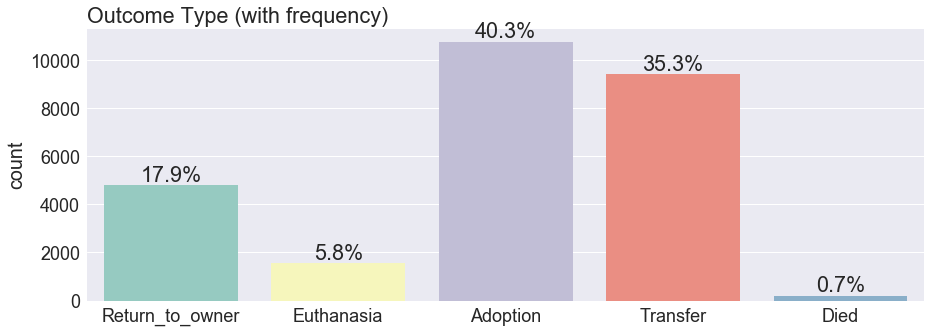

In [46]:
sns.set(font_scale=1.8)
ax = sns.countplot(data.OutcomeType, palette='Set3')
ax.figure.set_size_inches(15,5)
plt.title('Outcome Type (with frequency)', loc='left')
ax.set_xlabel('')
n = data.shape[0]
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/n), (x.mean(), y), 
                ha='center', va='bottom')

So the good news is the 75.6% of the animals are either adopted, or transferred to another place, and only very few animals (<1%) die while at the shelter, though a minority (5.8%) do get euthanized.

Let's look at the outcomes based on a particular feature, say AnimalType

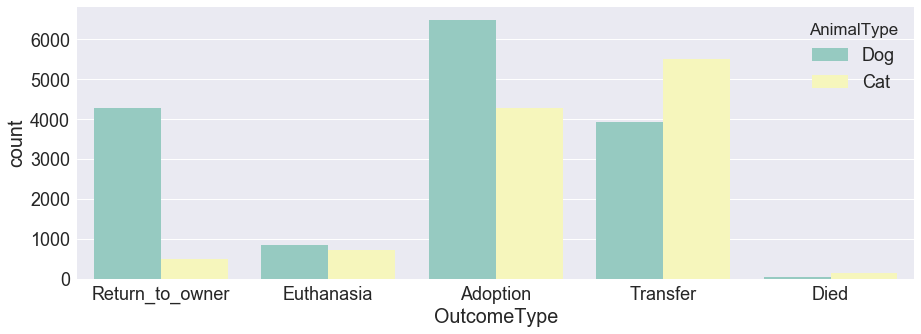

In [47]:
ax = sns.countplot(data=data, x='OutcomeType',hue='AnimalType', palette="Set3")
ax.figure.set_size_inches(15,5)

Here we see that more dogs are adopted compared to cats, but more cats are transferred. Interestingly, many more dogs are returned to owner compared to cats. The AnimalType variable looks like it could be very important in predicting the outcome. 

Let's now take a look at the name variable. There are too many unique names in the data, but a significant number of animals don't have a name. So to keep things simple, I want to compare the outcomes for named vs non-named animals. To do this, I'll need to change the name column to a binary column 'HasName', with value 1 indicating it has a name, and value 0 indicating it does not.

In [48]:
def HasName(x):
    if type(x) == float:
        return 0
    else:
        return 1

data['Name']=data['Name'].apply(HasName)

In [49]:
data.rename(columns={'Name':'HasName'}, inplace=True)

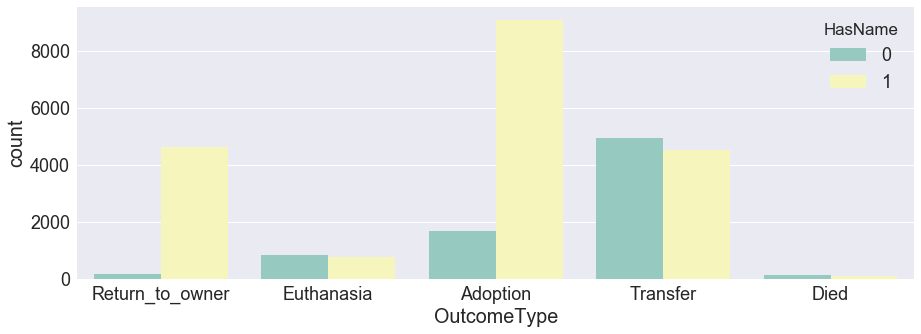

In [50]:
ax = sns.countplot(data=data, x='OutcomeType',hue='HasName', palette="Set3")
ax.figure.set_size_inches(15,5)

So we see that more named animals are returned to owner and adopted. But there were more named vs unnamed animals to begin with, and I want to make sure the difference we're seeing is not simply due to that fact. So I want to see the proportion of each group for each outcome. So let's create 2 more plots, 1 for named animals, and 1 for unnamed animals, so we can compare the outcomes between plots.

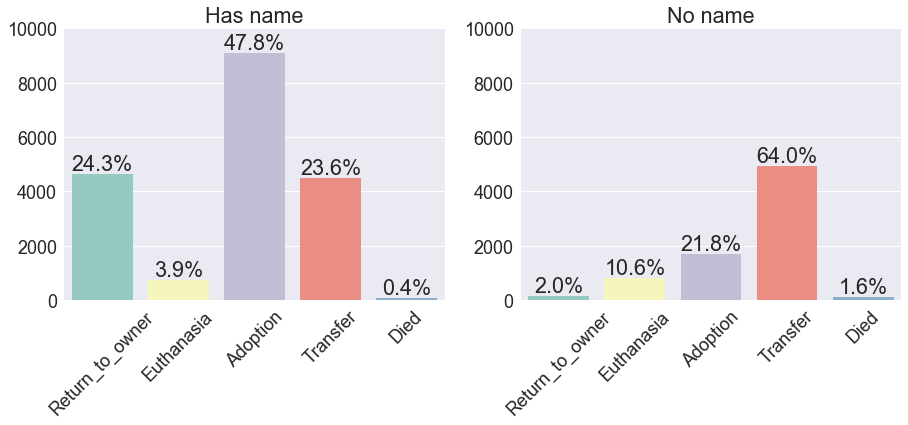

In [51]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,
                             squeeze=True, subplot_kw=None, gridspec_kw=None)
col_order = ['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died']
a = sns.countplot('OutcomeType', data = data[(data.HasName == 1)], palette='Set3', ax=ax1, order=col_order)
b = sns.countplot('OutcomeType', data = data[(data.HasName == 0)], palette='Set3', ax=ax2, order=col_order)
a.set_title('Has name')
b.set_title('No name')
a.set(ylabel='', xlabel='', ylim=(0,10000))
b.set(ylabel='', xlabel='', ylim=(0,10000))
for item in b.get_xticklabels():
    item.set_rotation(45)
for item in a.get_xticklabels():
    item.set_rotation(45)
ax1.figure.set_size_inches(15,5)
n1 = len(data[(data.HasName==1)])
for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{:.1f}%'.format(100.*y/n1), (x.mean(), y), 
                ha='center', va='bottom')
n2 = len(data[(data.HasName==0)])
for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{:.1f}%'.format(100.*y/n2), (x.mean(), y), 
                ha='center', va='bottom')

Now we can see clearly that if the animal has a name, almost half of these animals are adopted, while if it doesn't, less than a quarter are adopted. Similarly, 24.3% of named animals are returned to owner, compared to just 2% for unnamed animals. This variable is potentially very important in predicting the outcome.

Now let's look at the variable SexuponOutcome


Neutered Male    9780
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64


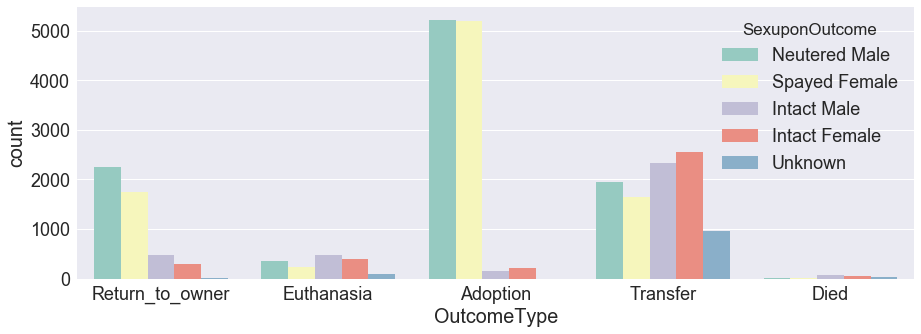

In [52]:
print(data.SexuponOutcome.value_counts())
ax = sns.countplot(data=data, x='OutcomeType',hue='SexuponOutcome', palette="Set3")
ax.figure.set_size_inches(15,5)

There are 9780 neutered males and 8820 spayed females, and more than 5000 from each category end up being adopted, with the majority of the remainder being either returned to owner, or transferred. 

On the other hand, there are 3525 intact males and 3511 intact females, and almost all of them are transfered, with the second most common outcome being euthanasia. I think we can safely say that neutered/spayed animals are more likely to get a better outcome. This is useful info the shelter could use. 

In [53]:
data.head()

,HasName,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,1,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,1,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,0,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,0,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


Now let's take a look at AgeuponOutcome. There are currently numerical values with different units (days, weeks, months, years), so to keep it simple, I'll convert all values to days.

In [54]:
def AgebyDay(x):
    num, unit = x.split(' ')
    if 'year' in unit:
        return int(num)*365
    elif 'month' in unit:
        return int(num)*30
    elif 'week' in unit:
        return int(num)*7
    elif 'day' in unit:
        return int(num)

In [55]:
data['AgeuponOutcome'] = data['AgeuponOutcome'].apply(AgebyDay)

In [56]:
data.head()

,HasName,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Return_to_owner,Dog,Neutered Male,365,Shetland Sheepdog Mix,Brown/White
1,1,Euthanasia,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby
2,1,Adoption,Dog,Neutered Male,730,Pit Bull Mix,Blue/White
3,0,Transfer,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream
4,0,Transfer,Dog,Neutered Male,730,Lhasa Apso/Miniature Poodle,Tan


Now let's look at the breed variable. We see that most of them are mixed breeds. There isn't a simple way to reduce the unique values of these breeds, without relying on outside data sources, so to keep things simple, I'll convert the variable into a binary variable indicating whether the breed is mixed.

In [57]:
def IsMix(x):
    if 'mix' in x or 'Mix' in x or '/' in x:
        return 1
    else:
        return 0

In [58]:
data['Breed'] = data['Breed'].apply(IsMix)

In [59]:
data.rename(columns={'Breed':'IsMixBreed'}, inplace=True)

In [60]:
data.head()

,HasName,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,IsMixBreed,Color
0,1,Return_to_owner,Dog,Neutered Male,365,1,Brown/White
1,1,Euthanasia,Cat,Spayed Female,365,1,Cream Tabby
2,1,Adoption,Dog,Neutered Male,730,1,Blue/White
3,0,Transfer,Cat,Intact Male,21,1,Blue Cream
4,0,Transfer,Dog,Neutered Male,730,1,Tan


I will ignore the color variable as I'm unsure of a reasonable way to deal with all the unique values.

In [67]:
del data['Color']

Separate the features(X) from the target(y)

In [75]:
y = data['OutcomeType']
X = data.drop(['OutcomeType'], axis=1)

Perform one-hot encoding to prepare data for use by the model.

In [93]:
X = pd.get_dummies(X)

# Algorithms

Since this is a multiclass classification problem, we are using a log loss metric, so it matters not just that we predict the accurate class, but that we do so with high probability, in order to get the best score. Since we have mostly categorical variables, and we don't have too much data (~26k rows, with 6 features), this would be ideal for ensemble tree-based classifiers. I will be running RandomForest and XGBoost classifiers. 

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

XGBoost is an algorithm that has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

**Benchmark**

To set a benchmark, we'll use a dummy classifier from sklearn. This is just a classifier that uses simple rules to make its prediction. Later we'll use real models to see if we can improve on the loss metric.

In [108]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
dummy = DummyClassifier(strategy='prior')
loss=[]
for train_index, test_index in skf.split(X,y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict_proba(X_test)
    loss.append(log_loss(y_test, y_pred))
print(loss)
print('Mean log loss for dummy model: ', np.mean(loss))

[1.2439119676165213, 1.243822919629386, 1.2431743174628553, 1.2431743174628553, 1.243236824648198]
Mean log loss for dummy model:  1.2434640693639634


The dummy classifier using the default strategy gets a log loss of ~20. But after switching to use the 'prior' strategy, it obtains its best score of 1.24. The Kaggle leaderboard has its top score at ~0.6 for those without the data exploit mentioned at the beginning (models using the data exploit can obtain a perfect 0 loss, which is unrealistic), so to jump from 20 to 1.24 is good. Let's see if we can improve from here with real models.

**Data preprocessing**

I've already done data preprocessing during the visualization stage. These include:
deleting unused columns,
filling null columns with the mode of the column,
changing Name to binary HasName,
changing Age from string to numeric day,
changing Breed to binary IsMixBreed,
and one hot encoding.

**Implementation**

Start with RandomForest

In [133]:
model = RandomForestClassifier()
loss=[]
for train_index, test_index in skf.split(X,y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    loss.append(log_loss(y_test, y_pred))
print(loss)
print('Mean log loss for model: ', np.mean(loss))

[1.2557486519884427, 1.3507544390191284, 1.3667122677731518, 1.3132522918599783, 1.2935886501829272]
Mean log loss for model:  1.3160112601647256


yikes, worse than the dummy model at the moment, try to improve by parameter tuning

**Refinement**

In [119]:
model = RandomForestClassifier()
params = {'n_estimators': [120, 500, 800],
          'criterion' : ['gini', 'entropy'],
          'min_samples_split' : [1.0, 5, 15, 100],
         }
clf = GridSearchCV(model, params, scoring = 'neg_log_loss', cv=5, verbose=2)
clf.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] criterion=gini, min_samples_split=1.0, n_estimators=120 .........
[CV]  criterion=gini, min_samples_split=1.0, n_estimators=120, total=   1.6s
[CV] criterion=gini, min_samples_split=1.0, n_estimators=120 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  criterion=gini, min_samples_split=1.0, n_estimators=120, total=   1.2s
[CV] criterion=gini, min_samples_split=1.0, n_estimators=120 .........
[CV]  criterion=gini, min_samples_split=1.0, n_estimators=120, total=   0.9s
[CV] criterion=gini, min_samples_split=1.0, n_estimators=120 .........
[CV]  criterion=gini, min_samples_split=1.0, n_estimators=120, total=   0.9s
[CV] criterion=gini, min_samples_split=1.0, n_estimators=120 .........
[CV]  criterion=gini, min_samples_split=1.0, n_estimators=120, total=   0.9s
[CV] criterion=gini, min_samples_split=1.0, n_estimators=500 .........
[CV]  criterion=gini, min_samples_split=1.0, n_estimators=500, total=   3.5s
[CV] criterion=gini, min_samples_split=1.0, n_estimators=500 .........
[CV]  criterion=gini, min_samples_split=1.0, n_estimators=500, total=   5.1s
[CV] criterion=gini, min_samples_split=1.0, n_estimators=500 .........
[CV]  criterion=gini, min_samples_split=1.0, n_estimators=500, total=   3.8s
[CV] criterion=gini, min_samples_sp

[CV]  criterion=gini, min_samples_split=100, n_estimators=800, total=  13.7s
[CV] criterion=gini, min_samples_split=100, n_estimators=800 .........
[CV]  criterion=gini, min_samples_split=100, n_estimators=800, total=  12.5s
[CV] criterion=gini, min_samples_split=100, n_estimators=800 .........
[CV]  criterion=gini, min_samples_split=100, n_estimators=800, total=  12.3s
[CV] criterion=entropy, min_samples_split=1.0, n_estimators=120 ......
[CV]  criterion=entropy, min_samples_split=1.0, n_estimators=120, total=   0.8s
[CV] criterion=entropy, min_samples_split=1.0, n_estimators=120 ......
[CV]  criterion=entropy, min_samples_split=1.0, n_estimators=120, total=   0.8s
[CV] criterion=entropy, min_samples_split=1.0, n_estimators=120 ......
[CV]  criterion=entropy, min_samples_split=1.0, n_estimators=120, total=   0.8s
[CV] criterion=entropy, min_samples_split=1.0, n_estimators=120 ......
[CV]  criterion=entropy, min_samples_split=1.0, n_estimators=120, total=   1.1s
[CV] criterion=entropy,

[CV]  criterion=entropy, min_samples_split=100, n_estimators=500, total=   7.5s
[CV] criterion=entropy, min_samples_split=100, n_estimators=500 ......
[CV]  criterion=entropy, min_samples_split=100, n_estimators=500, total=   7.6s
[CV] criterion=entropy, min_samples_split=100, n_estimators=500 ......
[CV]  criterion=entropy, min_samples_split=100, n_estimators=500, total=   9.0s
[CV] criterion=entropy, min_samples_split=100, n_estimators=800 ......
[CV]  criterion=entropy, min_samples_split=100, n_estimators=800, total=  10.9s
[CV] criterion=entropy, min_samples_split=100, n_estimators=800 ......
[CV]  criterion=entropy, min_samples_split=100, n_estimators=800, total=  10.8s
[CV] criterion=entropy, min_samples_split=100, n_estimators=800 ......
[CV]  criterion=entropy, min_samples_split=100, n_estimators=800, total=  10.7s
[CV] criterion=entropy, min_samples_split=100, n_estimators=800 ......
[CV]  criterion=entropy, min_samples_split=100, n_estimators=800, total=  10.8s
[CV] criterion

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 18.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [120, 500, 800], 'criterion': ['gini', 'entropy'], 'min_samples_split': [1.0, 5, 15, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=2)

In [143]:
loss=[]
for train_index, test_index in skf.split(X,y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]
    y_pred = clf.predict_proba(X_test)
    loss.append(log_loss(y_test, y_pred))
    print('train loss: ', clf.score(X_train, y_train), 'test loss: ', clf.score(X_test, y_test))
print(loss)
print('Mean log loss for model: ', np.mean(loss))

train loss:  -0.8186656660401392 test loss:  -0.8330948397224891
train loss:  -0.8202595011756352 test loss:  -0.8267239862170669
train loss:  -0.8250104667669473 test loss:  -0.8077189872957321
train loss:  -0.8208010733978136 test loss:  -0.8245597109263318
train loss:  -0.8230261397772018 test loss:  -0.8156564014417345
[0.8330948397224891, 0.8267239862170669, 0.8077189872957321, 0.8245597109263318, 0.8156564014417345]
Mean log loss for model:  0.8215507851206709


We get a much better score of 0.82 after parameter tuning. This is quite a bit better than the benchmark. Let's save this model, then try an XGBoost classifier.

In [137]:
dump(clf, 'clf.joblib')

['clf.joblib']

In [144]:
model = XGBClassifier(objective='multi:softprob', n_jobs=-1)
loss=[]
for train_index, test_index in skf.split(X,y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]
    model.fit(X_train, y_train, eval_metric='mlogloss')
    y_pred = model.predict_proba(X_test)
    loss.append(log_loss(y_test, y_pred))
print(loss)
print('Mean log loss for model: ', np.mean(loss))

[0.8429836325410812, 0.854020893450444, 0.8686741387717237, 0.8616905970849146, 0.8517967569537205]
Mean log loss for model:  0.8558332037603769


Default XGBoost got a score of 0.85, which is not too bad, but not as good as the tuned RandomForest model. Unfortunately, when I try tuning XGBoost using GridSearchCV, it is very slow and takes too long, and so for time constraint reasons, I will select the tuned RandomForests as the final model. 

**Model eval and validation**

RF model looks good, with a log loss of 0.82, and train and test loss being virtually identical at ~-0.82 (note the negative score is because the gridsearch used negative log loss as the scoring criteria).

**Justification**

We made significant progress compared to the benchmark, and with parameter tuning was able to get as high as 0.82. The Kaggle leaderboard is ~0.65 for models that don't use the data leak. So we're not far from the best models. I'm quite happy with the improvement in the score. Also with the train and test loss being virtually identical, I think the model is robust as there is no sign of overfitting, i.e. it is generalizing well.

# Conclusion

**Free-form visualization**

Let's look at the feature importance to get an idea of which features are the most useful for the model.

In [154]:
imp = clf.best_estimator_.feature_importances_

In [155]:
imp

array([0.17453236, 0.36970099, 0.00877312, 0.05221419, 0.05320816,
       0.09478246, 0.09280784, 0.07061231, 0.06297567, 0.0203929 ])

In [159]:
cols = X.columns
cols

Index(['HasName', 'AgeuponOutcome', 'IsMixBreed', 'AnimalType_Cat',
       'AnimalType_Dog', 'SexuponOutcome_Intact Female',
       'SexuponOutcome_Intact Male', 'SexuponOutcome_Neutered Male',
       'SexuponOutcome_Spayed Female', 'SexuponOutcome_Unknown'],
      dtype='object')

In [162]:
indices = np.argsort(imp)[::-1]
length = len(cols)
indices

array([1, 0, 5, 6, 7, 8, 4, 3, 9, 2])

[Text(0,0.5,'Importance(%)'), Text(0.5,0,'Columns')]

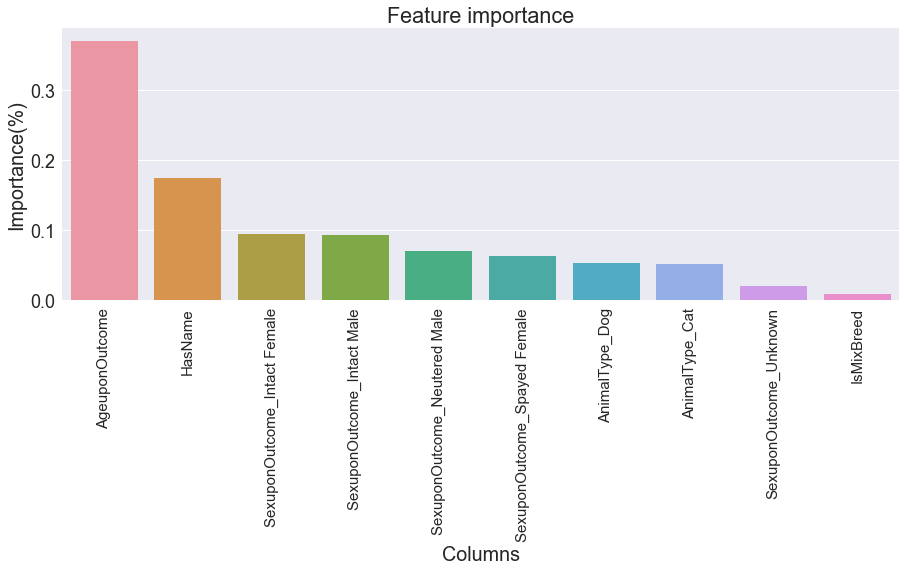

In [176]:
# plt.title('Feature Importances')
# plt.bar(range(length),imp[indices[:length]],color='lightblue',align='center')
# plt.xticks(range(length),cols[indices[:length]],rotation=90)
# plt.xlim([-1,length])
# plt.show()
# plt.gcf.size_in_inches(15,5)
ax = sns.barplot(x=cols[indices], y=imp[indices])
ax.figure.set_size_inches(15,5)
for item in ax.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(15)
ax.set_title('Feature importance')
ax.set(ylabel='Importance(%)', xlabel='Columns')

We see the age had the biggest impact(understandable, as puppies are more likely to be adopted than old dogs, for example), followed by whether or not the animal has a name(we saw this in exploratory analysis). However, we one-hot encoded the SexuponOutcome column that got split into 5 different columns, which if we add up their importance, would be roughly similarly important as the AgeuponOutcome. We saw that neutered and spayed animals are more likely to get good outcomes. IsMixBreed isn't very important, we perhaps needed to be cleverer in how we handled this column's data to get more use out of it. 

**Reflection**

Overview of the steps: Find the dataset on Kaggle and download it. Exploratory analysis and visualizations were helpful to understand the data and already give insights into which features are important for predicting outcome. Needed to clean up some data such as age etc (feature engineering), as well as data processing for use by the models. Had difficulty with Breed and Color, ended up not using them in the prediction. Ran a dummy model to get a benchmark, followed by training 2 proper models using grid search for parameter tuning, which beat the benchmark and got pretty good scores. We evaluated the models using the log loss metric and finally displayed the feature importance of the data. 

Interesting aspects: the exploratory analysis to see what sort of values we have for the different features, including some which had many null values that had to be dealt with (the Name column, which actually let us engineer a new feature of whether or not the animal has a name, as it could potentially affect the outcome), some visualization already gave us clues as to which features are going to be important, e.g. it's important to have a name and be neutered/spayed to have a higher chance of adoption. Difficult aspects are columns Breed and Color. Too many unique values. Tried to simplify breed, but didn't end up being too useful for prediction. Parameter tuning for XGBoost was also very slow, ended up having to abandon that. I think the final model could be used by the shelter to estimate the likelihood of good/bad outcomes and take action accordingly, for example if an animal has a lower chance of being adopted, maybe they could reduce the adoption fee for that animal or offer other incentives. 

**Improvement**

Could make use of more of the features. E.g. Perhaps we could simplify the Breed column by converting it into a DogType column, for example splitting the dog breeds into dog categories, such as 'toy', 'hound' etc., or extracting more information from the breeds, example the dog size and weight, intelligence, aggressiveness. These could all be useful features to help classification. We would need to obtain data separately from other sources regarding the dog breeds to do this analysis. Similarly for the color, we could probably group them into 'light', 'medium', 'dark'. We could try more parameters for tuning, especially on XGBoost, and try more models, perhaps linear models like SVM or logistic regression.